# Inference procedures for the estimation of kinetic parameters from kinetic locking data.

In [167]:
import numpy as np
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas
import scipy.special
import scipy.stats

plt.style.use("mr")
  
try:
    plt.style.use("mr")
except:
    plt.style.use('http://www.normalesup.org/~mrieu/Python/stylelib/mr.mplstyle')
plt.style.reload_library()
from scipy.optimize import curve_fit
import re
from pomegranate import *

err_conc = 0.1



## Preprocessing of data files

In [168]:
def read_dir(fold): 
    """
    Read a folder comprised of seperate files for each concentration named "XXXuM.csv"
    Each file contains a list of times spent in the closed or open states
    Returns a list of concentration and list of arrays of the same size
    Each array contains all the times associated to a concentration
    """

    flist=os.listdir(fold)
    conc=[]
    times = []
    duration = []
    for f in flist:
        if f.endswith("nM.csv") or f.endswith("uM.csv"):
            print(f)
            b = re.findall(r'\d+', f)
            print(b)
            if (len(b) > 1):
                b[0] = float(str(b[0])+'.'+str(b[1]))
            dis = np.genfromtxt(fold+f,delimiter=";",skip_header=1)
            conc.append(float(b[0]))
            times.append(dis[:,1])
            duration.append(dis[-1,0]) #duration of the recording
    return times, conc, duration

            

def read_times_to_flatdis(times,conc,bins,binmean = 1):
    """
    Read a list of concentration and a list of times arrays for each concentration.
    Times arre binned according to the bins indicated in arguments. 
    The bins are centered in their middle (binmean = 0) or in the mean of the values belonging 
    to each of them (binmean = 1)
    Return an unique array where the concentration is indicated in a separated row
    
    """

    start = 1
    for i in range(len(conc)):
            binsh = np.copy(bins)
            retry = 1
            while retry:
                retry = 0
                dis = times[i]
                n,p = np.histogram(dis,binsh)
                no_pts = np.where(n==0)[0]
                if len(no_pts) != 0:
                    binsh = np.delete(binsh,no_pts+1)
                    retry = 1
            binsc = 0.5*p[:-1]+0.5*p[1:]
            binswidth = p[1:] - p[:-1]
            binsc, po, po = scipy.stats.binned_statistic(dis,dis, statistic='mean', bins=binsh, range=None)
            n = n[np.newaxis]
            sigma = np.sqrt(n)
            n = n/np.sum(n)
            n = n/binswidth
            sigma = n/sigma*1.3
            if (binmean == 0):
                binsc = 0.5*p[:-1]+0.5*p[1:]

            n = np.transpose(n)
            mean = np.mean(dis)
            fldis = np.insert(n,0,conc[i],axis=1)
            fldis = np.insert(fldis,1,binsc,axis=1)
            fldis = np.insert(fldis,3,0,axis=1)
            fldis = np.insert(fldis,4,sigma,axis=1)
            fldis = np.insert(fldis,5,mean,axis=1)
            if (start == 1):
                flatdis = np.copy(fldis)
            else:
                flatdis = np.vstack((flatdis,fldis))
            start += 1      
    return flatdis

def sf(number): #routine that returns a number in scientific format
    return "{:.2e}".format(number)
    

## Definition of fitted functions

In [169]:
def multi_exp(data,a):
    """
    Double exponential with proportion of large time being proportional to the concentration
    """
    t = data[:,1] # time
    c = data[:,0] # concentration
    return (1-a*c)*np.exp(-t/t1)/t1+(a*c)*np.exp(-t/t2)/t2
def multi_exp(data,a):
    """
    Double exponential with fixed proportion of large time
    Concentration is not taken in account
    """
    t = data[:,1]
    return (1-a)*np.exp(-t/t1)/t1+a*np.exp(-t/t2)/t2
def exact_function(data,kon0,koffi,deltagun,kf):
    """
    Fit the model of kinetic model to the data
    Here the model is constrained either by enforcing koffi
    Or deltag (log ration of kon/koff)
    """
    
    t = data[:,1]
    c = data[:,0]
    kon = kon0*c
    if (koffi == -1):
        
        koff = kon0/np.exp(deltagun) 
    else:
        koff = koffi

    delta = np.sqrt((kf+kon+koff)**2-4*koff*kf)
    l1 = -0.5*(kf+kon+koff) - 0.5 * delta
    l2 = -0.5*(kf+kon+koff) + 0.5* delta
    a1 = (l1 + koff) / kon
    a2 = (l2 + koff) / kon
    res = kf/(a1-a2)*(a1*np.exp(l1*t)-a2*np.exp(l2*t))
    ind = np.where(c==0)[0]

    res[ind] = kf*np.exp(-kf*t[ind])

    return res
def exact_function_kk(data,kon0,koff,kf):
    """
    Fit the model of kinetic model to the data
    Here the model is unconstrained. 
    Kon and koff are inferred indepdently
    """
    
    t = data[:,1]
    c = data[:,0]
    kon = kon0*c
    delta = np.sqrt((kf+kon+koff)**2-4*koff*kf)
    l1 = -0.5*(kf+kon+koff) - 0.5 * delta
    l2 = -0.5*(kf+kon+koff) + 0.5* delta
    ind = np.where(c==0)[0]
    kon[ind] = 1 #hack to avoid divived by 0

    a1 = (l1 + koff) / kon
    a2 = (l2 + koff) / kon
    res = kf/(a1-a2)*(a1*np.exp(l1*t)-a2*np.exp(l2*t))
    res[ind] = kf*np.exp(-kf*t[ind]) # true distribution for 0 concentration


    return res

def prop_long_times_vs_conc(times,conc,kf,koff):
    """
    Draw real proportion of short and long times times as a function of concentration
    Uses fitted kf and koff, provided in arguments
    Predict the number of events belonging to the koff part
    """
    prop_c = []
    prop_er = []
    for i in range(len(conc)):
        ts = times[i]
        d1 = ExponentialDistribution(kf)
        d1.freeze()
        d2 = ExponentialDistribution(koff)
        d2.freeze()
        clf = GeneralMixtureModel([d1, d2])
        clf.fit(ts)
        wts = np.exp(clf.weights)
        prop_c.append(wts[1])
        prop_er.append(prop_c[-1]/np.sqrt(wts[1]*len(ts))) #error : 1/sqrt(nb_events)
    plt.errorbar(conc,prop_c,yerr=prop_er,xerr=np.asarray(conc)*err_conc,fmt='.')
    plt.xlabel("Concentration (nM)")
    plt.ylabel("Proportion of long times ")
    conc = np.asarray(conc)
    z = np.where(conc == 0)[0]
    weights = np.reciprocal(prop_er)
    weights[z] = 1e6
    a,b = np.polyfit(conc,prop_c,1,w=weights)
    plt.plot(conc,conc*a+b)
    return prop_c

def kon_vs_conc_all_bound(times,conc,duration,kf,koff):
    """
    Uses fitted kf and koff, to compute the most probable distribution
    from which each of the times is extracted
    Divides the whole time of the experiment minus the time spent in the long states
    by the number of long binding events.
    Is appropriate to compute kon in the case where binding can happen in both the open
    and closed states. 
    Prediction are made using expectation maximization using the module pomegranate
    """
    prop_c = []
    prop_er = []
    for i in range(len(conc)):
        ts = times[i]
        d1 = ExponentialDistribution(kf) #use fitted parameter for kf
        d1.freeze()
        d2 = ExponentialDistribution(koff) #use fitted parameters for koff
        d2.freeze() #freeze parameters
        clf = GeneralMixtureModel([d1, d2])
        clf.fit(ts) #compute proportion of both times for the fitted parameters
        nb_long = np.exp(clf.weights[1]) * len(ts) #absolute number of long times
        pr = clf.predict(np.reshape(ts,(-1,1))) # predict the appartenance of each of the individiaul times
        whole_time_not_bound = duration[i] - np.sum(pr*ts) #sum of the duration of the free states (whole experiment time minus long times)
        prop_c.append(nb_long/whole_time_not_bound) # proportion of 
        prop_er.append(prop_c[-1]/np.sqrt(nb_long))
        
    plt.errorbar(conc,prop_c,yerr=prop_er,xerr=np.asarray(conc)*err_conc,fmt='.')
    plt.xlabel("Concentration (nM)")
    plt.ylabel("Number of long binding times divided \n"
   "by time spent in the free state ($s^{-1}$)")
    weights = np.reciprocal(np.asarray(prop_er))
    
    conc = np.asarray(conc)
    z = np.where(conc == 0)[0]
    weights[z] = 1e6
    a,b = np.polyfit(conc,prop_c,1,w=weights)


    plt.plot(conc,conc*a+b)
    return a




## Fitting and bootstrapping procedure 

In [170]:

#bins = np.linspace(0,1,num=30)

#bins = np.logspace(-3, 0, base=10,num=50)
def draw_multifit(flatdis,deltag=-1,koffi=-1,kons=0.02,koffs=1,plot=0,xl=[0,0.4],yl=[0.00001,40]):
    """
    Fit the model of kinetic model to the data 
    Can eventually be constrained by deltag or koffi
    Draw curves if plot = 1
    Return inferred kon and koff   
    """

    conc = np.unique(flatdis[:,0])

    tar=np.arange(0,yl[1],0.001)
    ind = np.where(flatdis[:,0]==0)[0]
    tf=flatdis[ind,5][0]
    kf = 1/tf
    if deltag  != -1:
        deltagun = -deltag/0.5919 #en kT
        deltagun -= np.log(1e6) #ln (ratio kon koff)
    else:
        deltagun = -1

    if (deltag != -1 or koffi != -1):
            params, pcov = curve_fit(lambda x, kon: exact_function(x,kon,koffi,deltagun,kf),\
                    flatdis[:,:2], flatdis[:,2], [kons],sigma=flatdis[:,4])
            kon0 = params[0]
            if (koffi != -1):
                koff = koffi
            else:
                koff = kon0/np.exp(deltagun)
    else:
            params, pcov = curve_fit(lambda x,kon,koff :exact_function_kk(x,kon,koff,kf),\
                    flatdis[:,:2], flatdis[:,2], [kons,koffs],sigma=flatdis[:,4])
            kon0 = params[0]
            koff = params[1]

    for c in conc:
        if (plot):
            ax=plt.gca()
        ind = np.where(flatdis[:,0]==c)[0]


        flatdis[ind,4] = np.minimum(flatdis[ind,4],0.9*flatdis[ind,2])


        if plot:
            color = next(ax._get_lines.prop_cycler)['color']
            plt.errorbar(flatdis[ind,1],flatdis[ind,2],yerr=flatdis[ind,4],capsize = 2, fmt='x',label=str(c)+ "nM",markersize=4,color=color)
        data = np.transpose(np.array([[c]*len(tar),tar]))

        if plot:
            
            plt.plot(tar,exact_function_kk(data,kon0,koff,kf),'-',linewidth=1,color=color)

    if plot:

        plt.yscale("log")
        plt.ylim(yl)
        plt.xlim(xl)
        plt.xlabel("$T_{open} (s)$")
        plt.ylabel("Probability density $(s^{-1})$")
        plt.legend(fontsize=11)
    return kon0,koff,kf
def bootstrap_multifit(times,conc,bins,deltag=-1,koffi=-1,kons=0.02,koffs=1,plot=0):
    """
    Compute kon and koff distribution by bootstrap resampling
    The times are first randomly selected with replacement
    The fit is then performed.
    The operation is reproduced 100 times.
    Return mean and standard deviation of kon and koff over the 1000 samples
    """
    kon = []
    koff = []
    L = len(times)
    for i in range(100):  
        times_samp = []
        for j in range(len(times)):
            sample_n = np.random.choice(times[j], size=len(times[j]),replace=True)
            times_samp.append(sample_n)

        flatdis = read_times_to_flatdis(times_samp,conc,bins)

        a,b,kf = draw_multifit(flatdis,deltag,koffi,kons,koffs,0)
        kon.append(a)
        koff.append(b)
    print("kon = " + sf(np.mean(kon)) + " +- " + sf(np.std(kon))) 
    print("koff = " + sf(np.mean(koff)) + " +- " + sf(np.std(koff))) 
    return np.mean(koff),np.std(koff),np.mean(kon),kf



# Example 1 : Open times of a substrate without ssDNA in the presence of various concentrations of RecQ-DeltaC

0nM.csv
['0']
100nM.csv
['100']
2.4nM.csv
['2', '4']
24nM.csv
['24']


(0.010974716412371046, 11.213195546477692, 71.24846192527528)

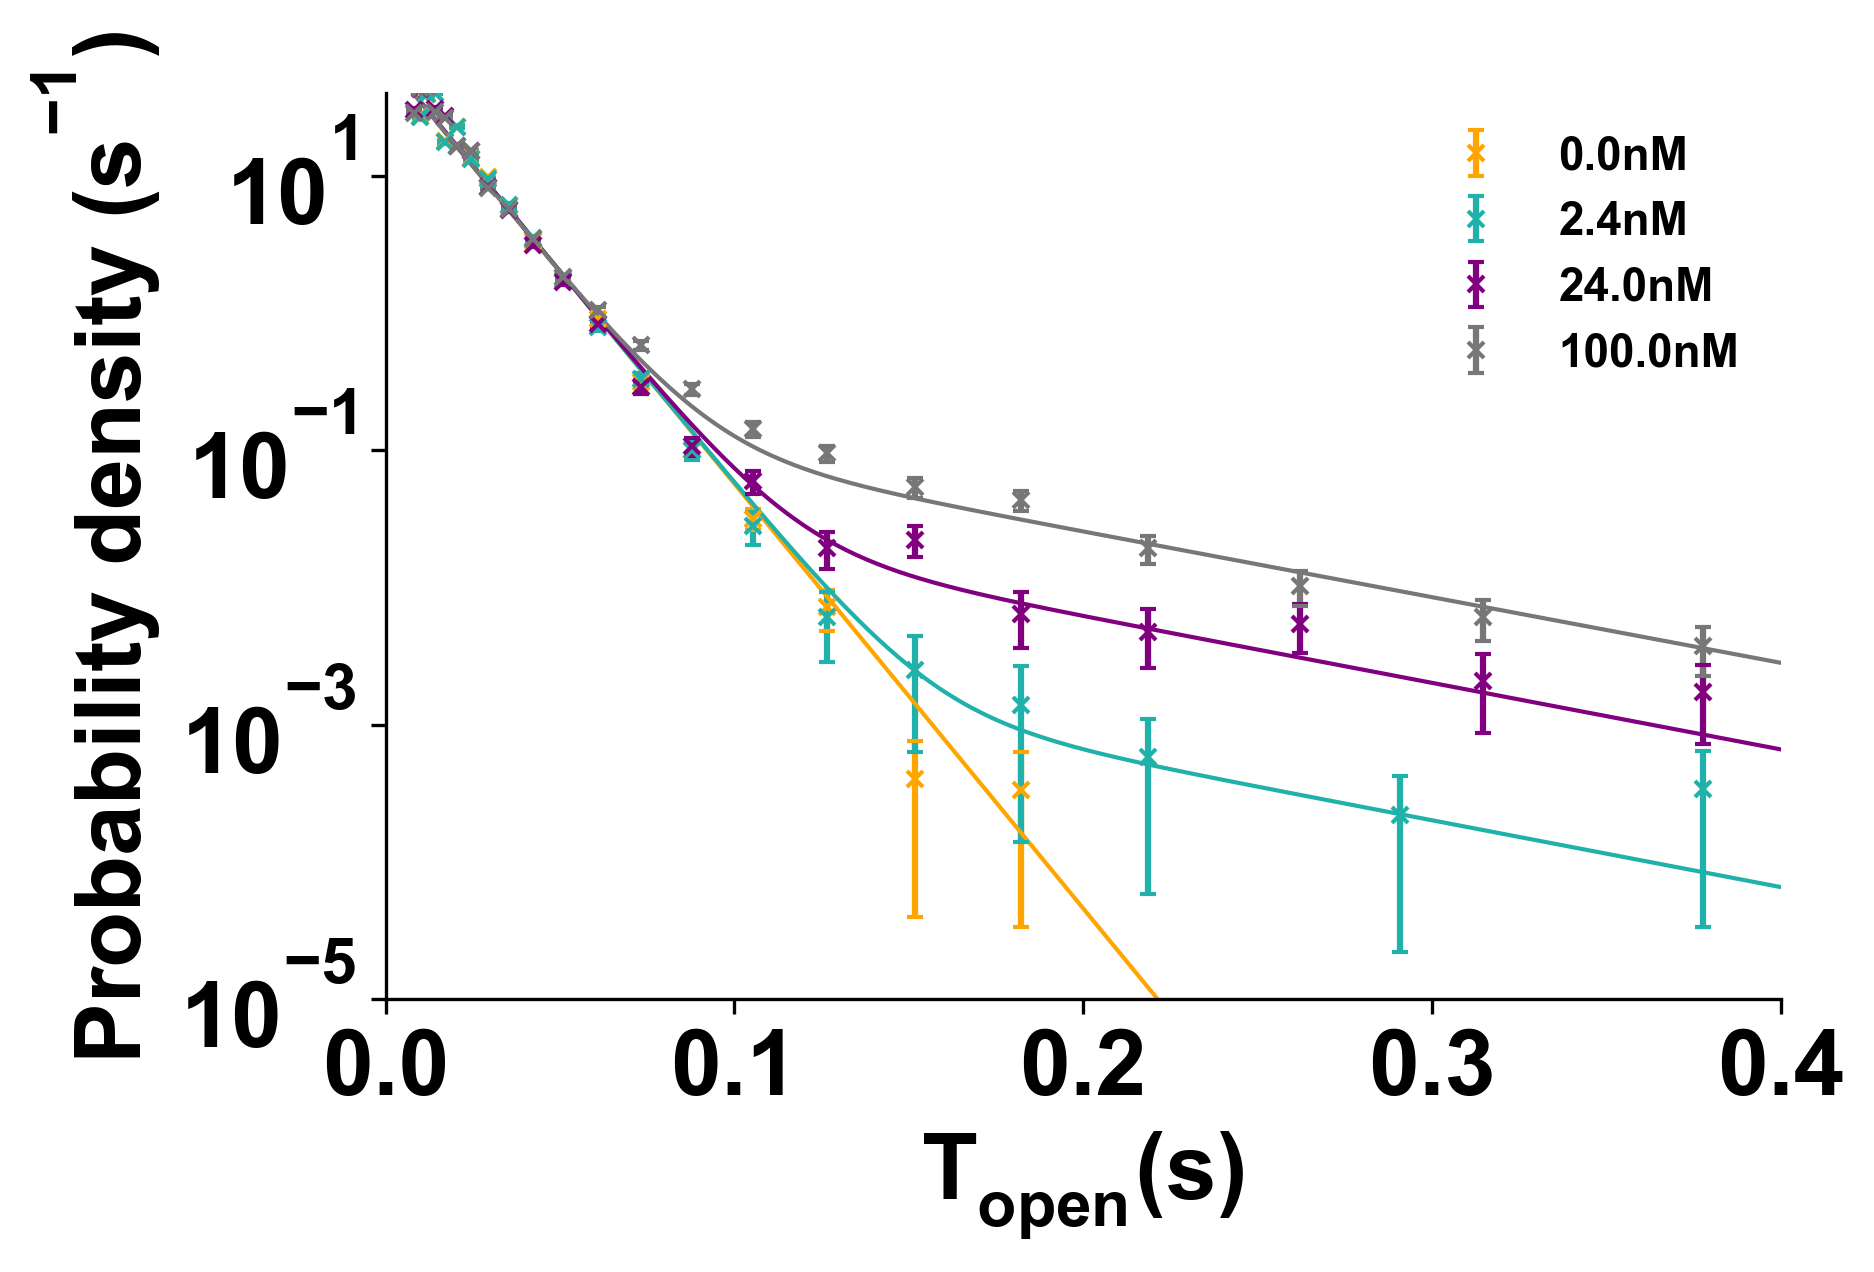

In [171]:
bins = np.logspace(-2.5,-1,num=20)
bins = [0.003]
while bins[-1]<5:
    bins.append(bins[-1]*1.2)

times,conc, duration = read_dir("../RecQ_no_fourche_2020_08_26/")
flatdis = read_times_to_flatdis(times,conc,bins,binmean=0)
draw_multifit(flatdis,deltag=-1,koffi=-1,kons=0.02,koffs=8,plot=1)


In [172]:
koff,koffstd,kon,kf = bootstrap_multifit(times,conc,bins,deltag=-1,koffi=-1,kons=0.02,koffs=8,plot=0)


kon = 9.92e-03 +- 8.15e-04
koff = 1.09e+01 +- 6.58e-01


[9.29039292816554e-06,
 0.019744591673608248,
 0.0005686955469024867,
 0.004058544917573484]

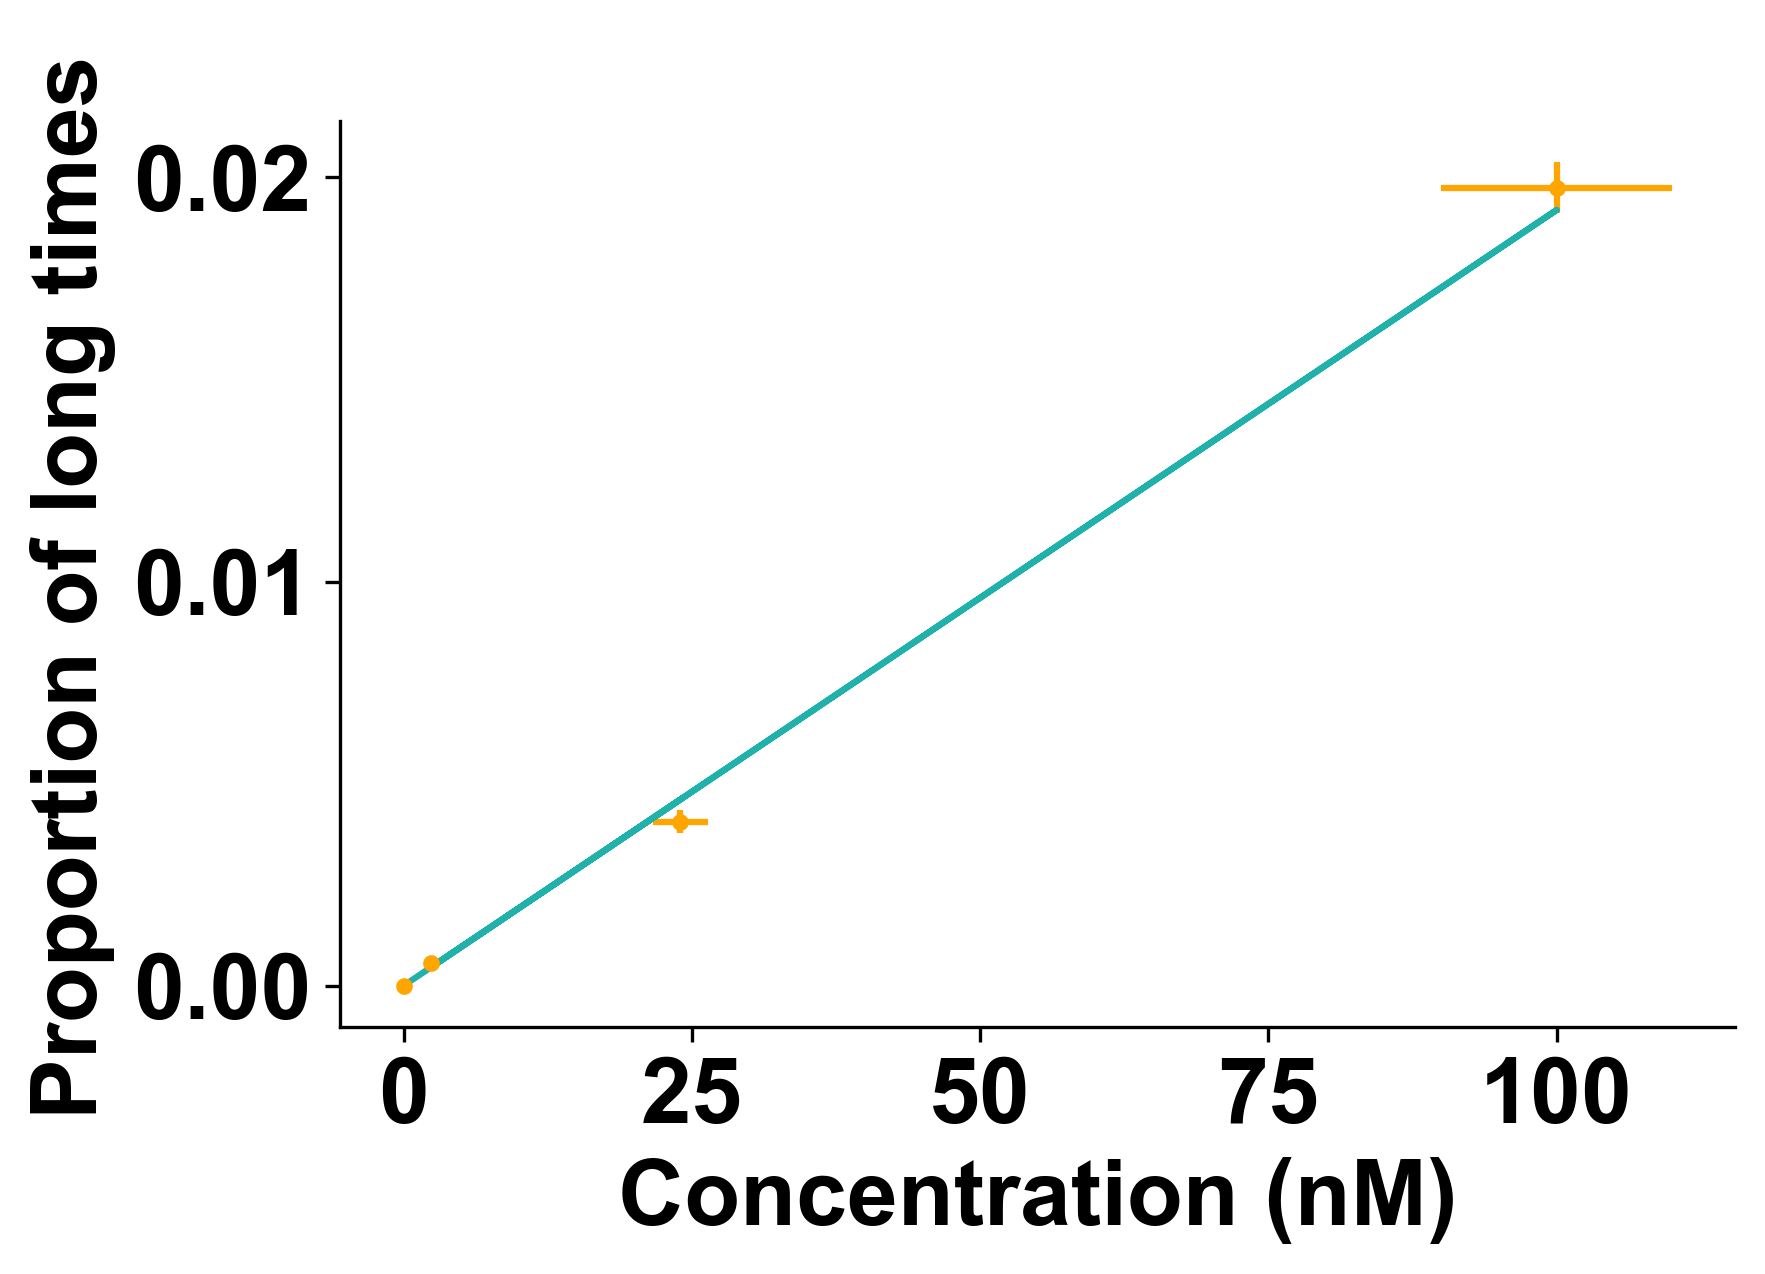

In [174]:

prop_long_times_vs_conc(times,conc,kf,koff)


# Example 2 : closed times of a substrate with ssDNA in the presence of various concentrations of RecQ-DeltaC

4.8nM.csv
['4', '8']
1.2nM.csv
['1', '2']
0nM.csv
['0']
2.4nM.csv
['2', '4']


(0.13198301334899404, 0.9206835618240463, 66.34041004106896)

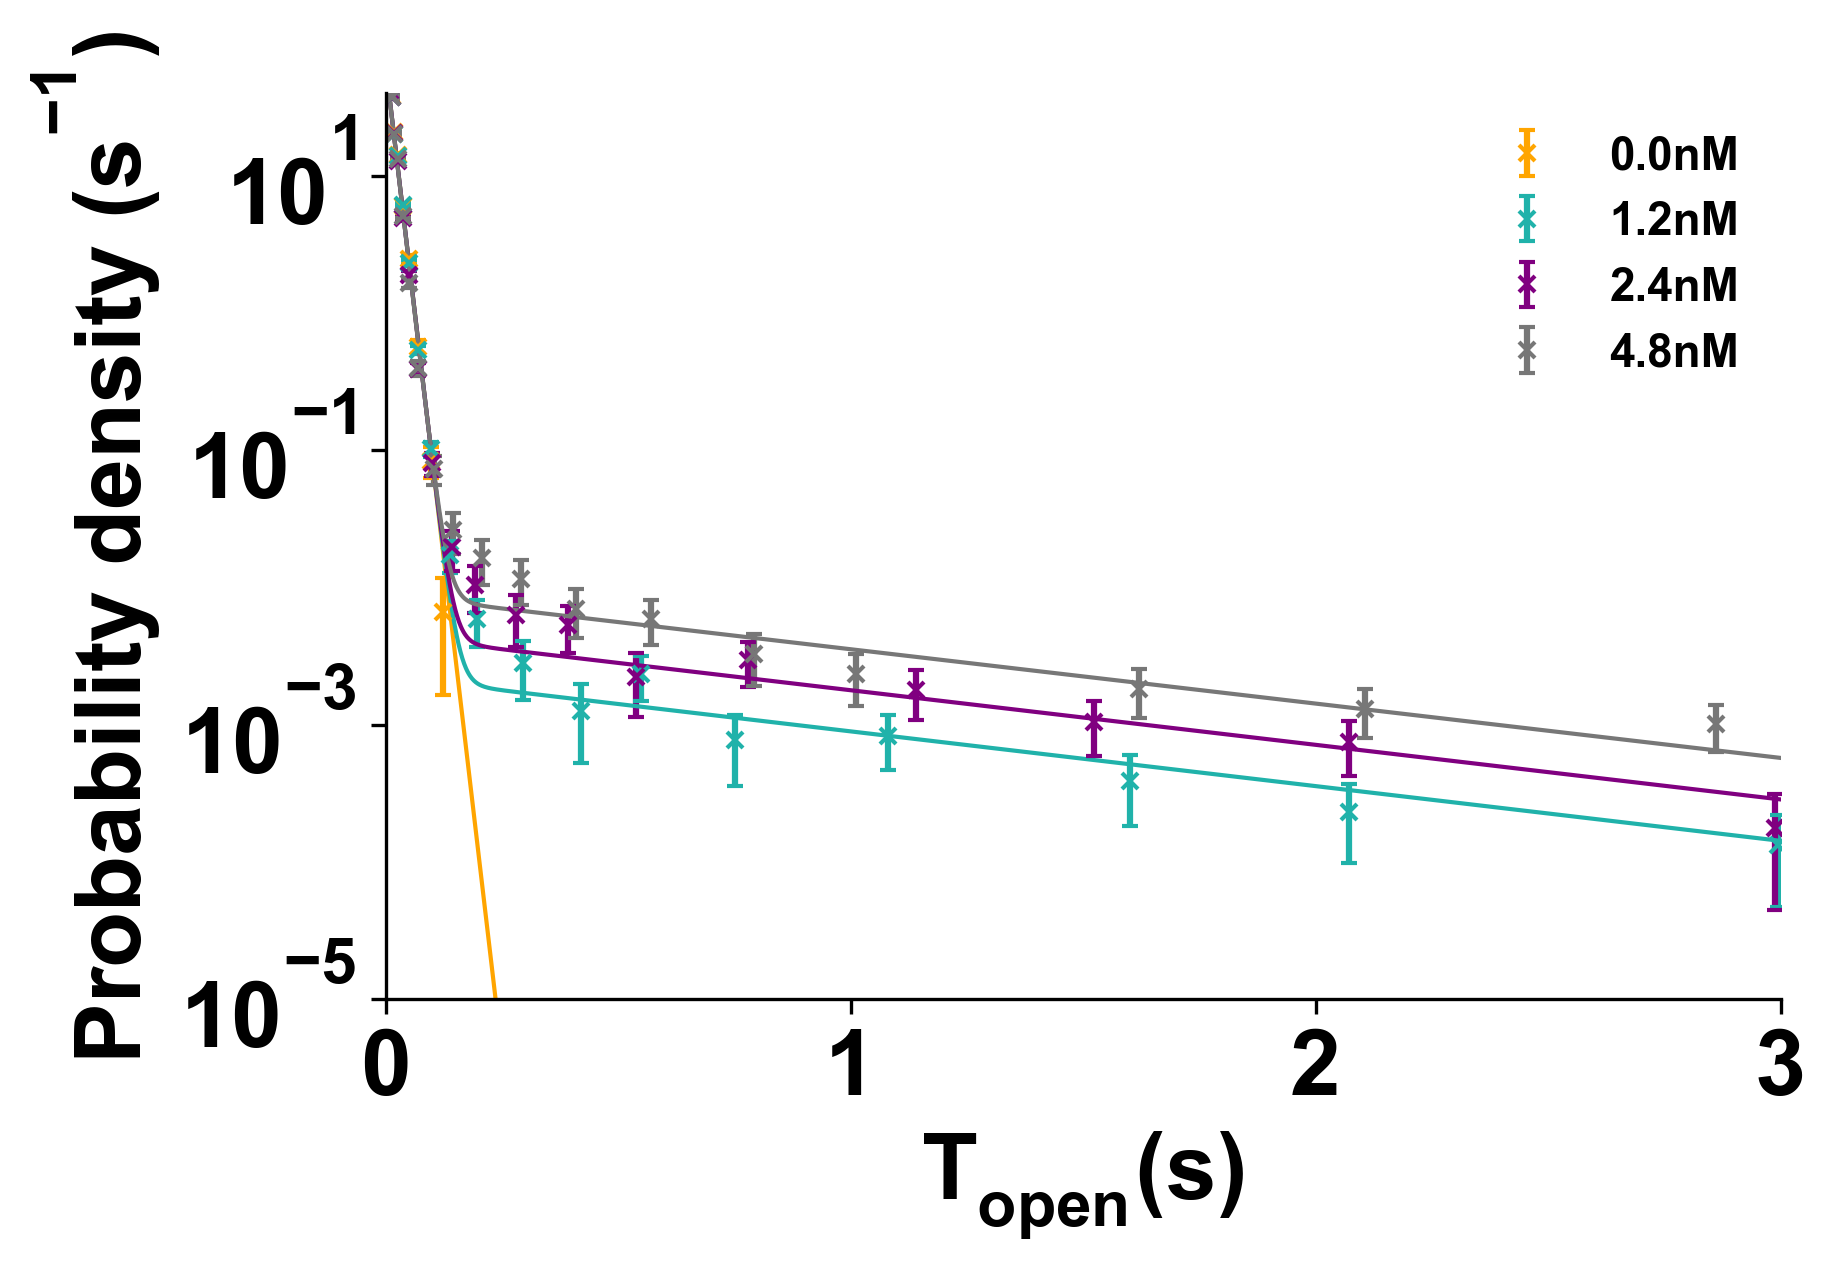

In [175]:
bins = np.logspace(-2.5,-1,num=20)
bins = [0.003]
while bins[-1]<5:
    bins.append(bins[-1]*1.4)

times,conc, duration = read_dir("../RecQ_fourche_HF_2020_09_10/")
flatdis = read_times_to_flatdis(times,conc,bins,binmean=1)
draw_multifit(flatdis,deltag=-1,koffi=-1,kons=0.02,koffs=8,plot=1,xl=[0,3],yl=[0.00001,40])



In [176]:
koff, koffstd, kon, kf = bootstrap_multifit(times,conc,bins,deltag=-1,koffi=-1,kons=0.02,koffs=8,plot=0)


kon = 1.16e-01 +- 1.33e-02
koff = 9.29e-01 +- 2.36e-01


0.0643101249238077

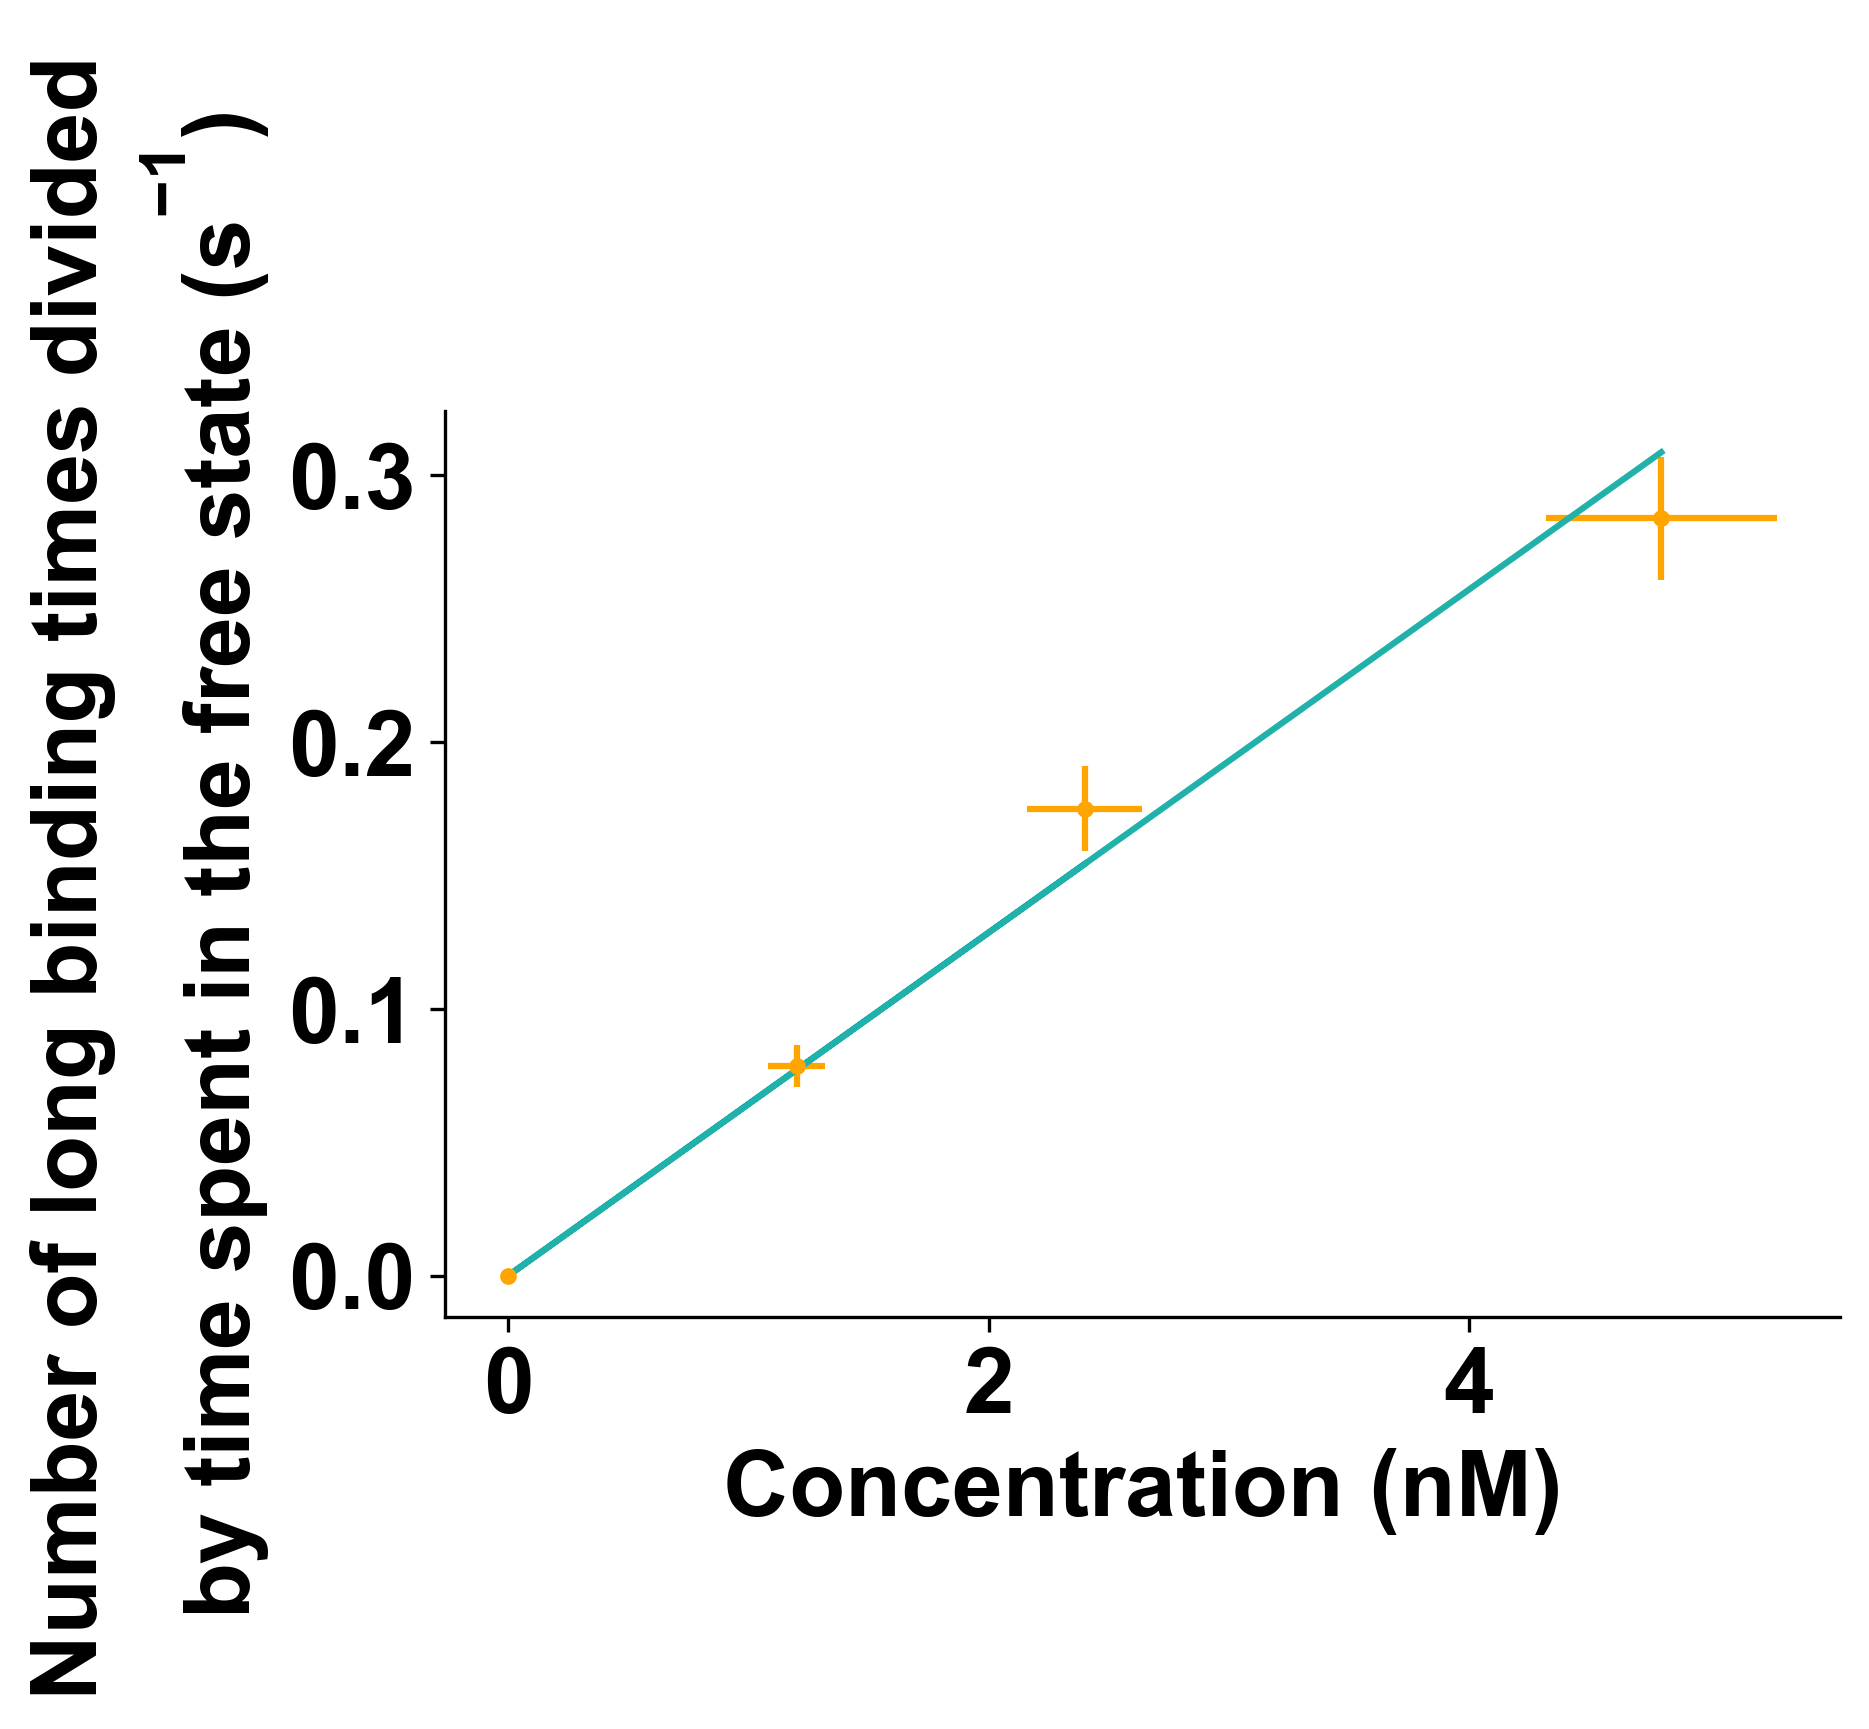

In [177]:
kon_vs_conc_all_bound(times,conc,duration,kf,koff)

# Example 3 : Open times for various concentrations of an oligonucleotide of  7 bases

0.2uM.csv
['0', '2']
0uM.csv
['0']
0.1uM.csv
['0', '1']
0.6uM.csv
['0', '6']
0.4uM.csv
['0', '4']
0.8uM.csv
['0', '8']


/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


(7.01525186780809, 4.426180531938079, 76.71202969488277)

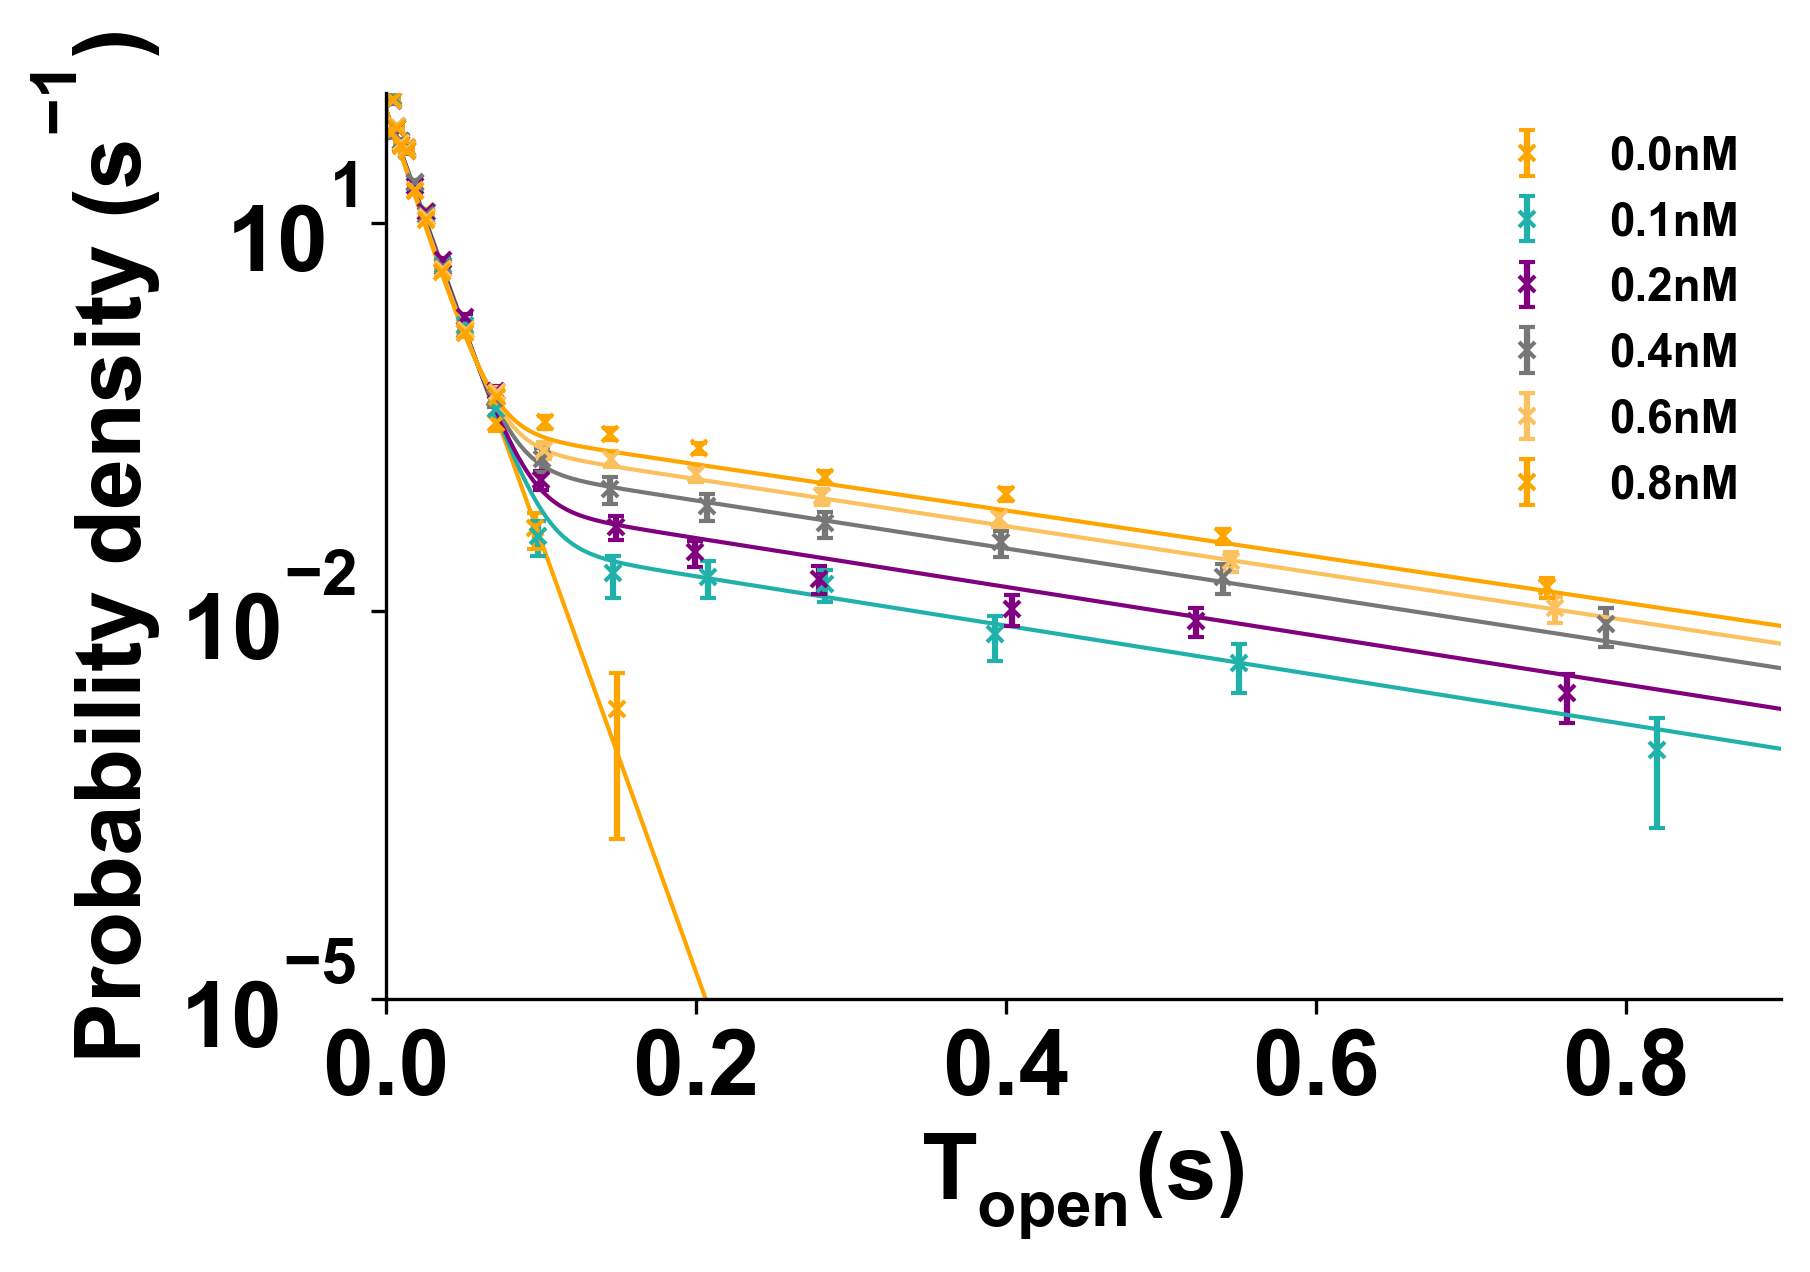

In [178]:
bins = np.logspace(-2.5,-1,num=20)
bins = [0.003]
while bins[-1]<5:
    bins.append(bins[-1]*1.4)

times,conc,duration = read_dir("./2020_09_01/")
flatdis = read_times_to_flatdis(times,conc,bins,binmean=1)
draw_multifit(flatdis,deltag=-8.45,koffi=-1,kons=6,koffs=4,plot=1,xl=[0,0.9],yl=[0.00001,100])
#delta g comes from the fit of the mean times ()

In [179]:
koff,koffstd,kon,kf=bootstrap_multifit(times,conc,bins,deltag=-8.45,koffi=-1,kons=6,koffs=4,plot=0)



/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/lib/python3/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


kon = 6.89e+00 +- 2.18e-01
koff = 4.35e+00 +- 1.38e-01


Text(0.5, 0, 'Concentration (uM)')

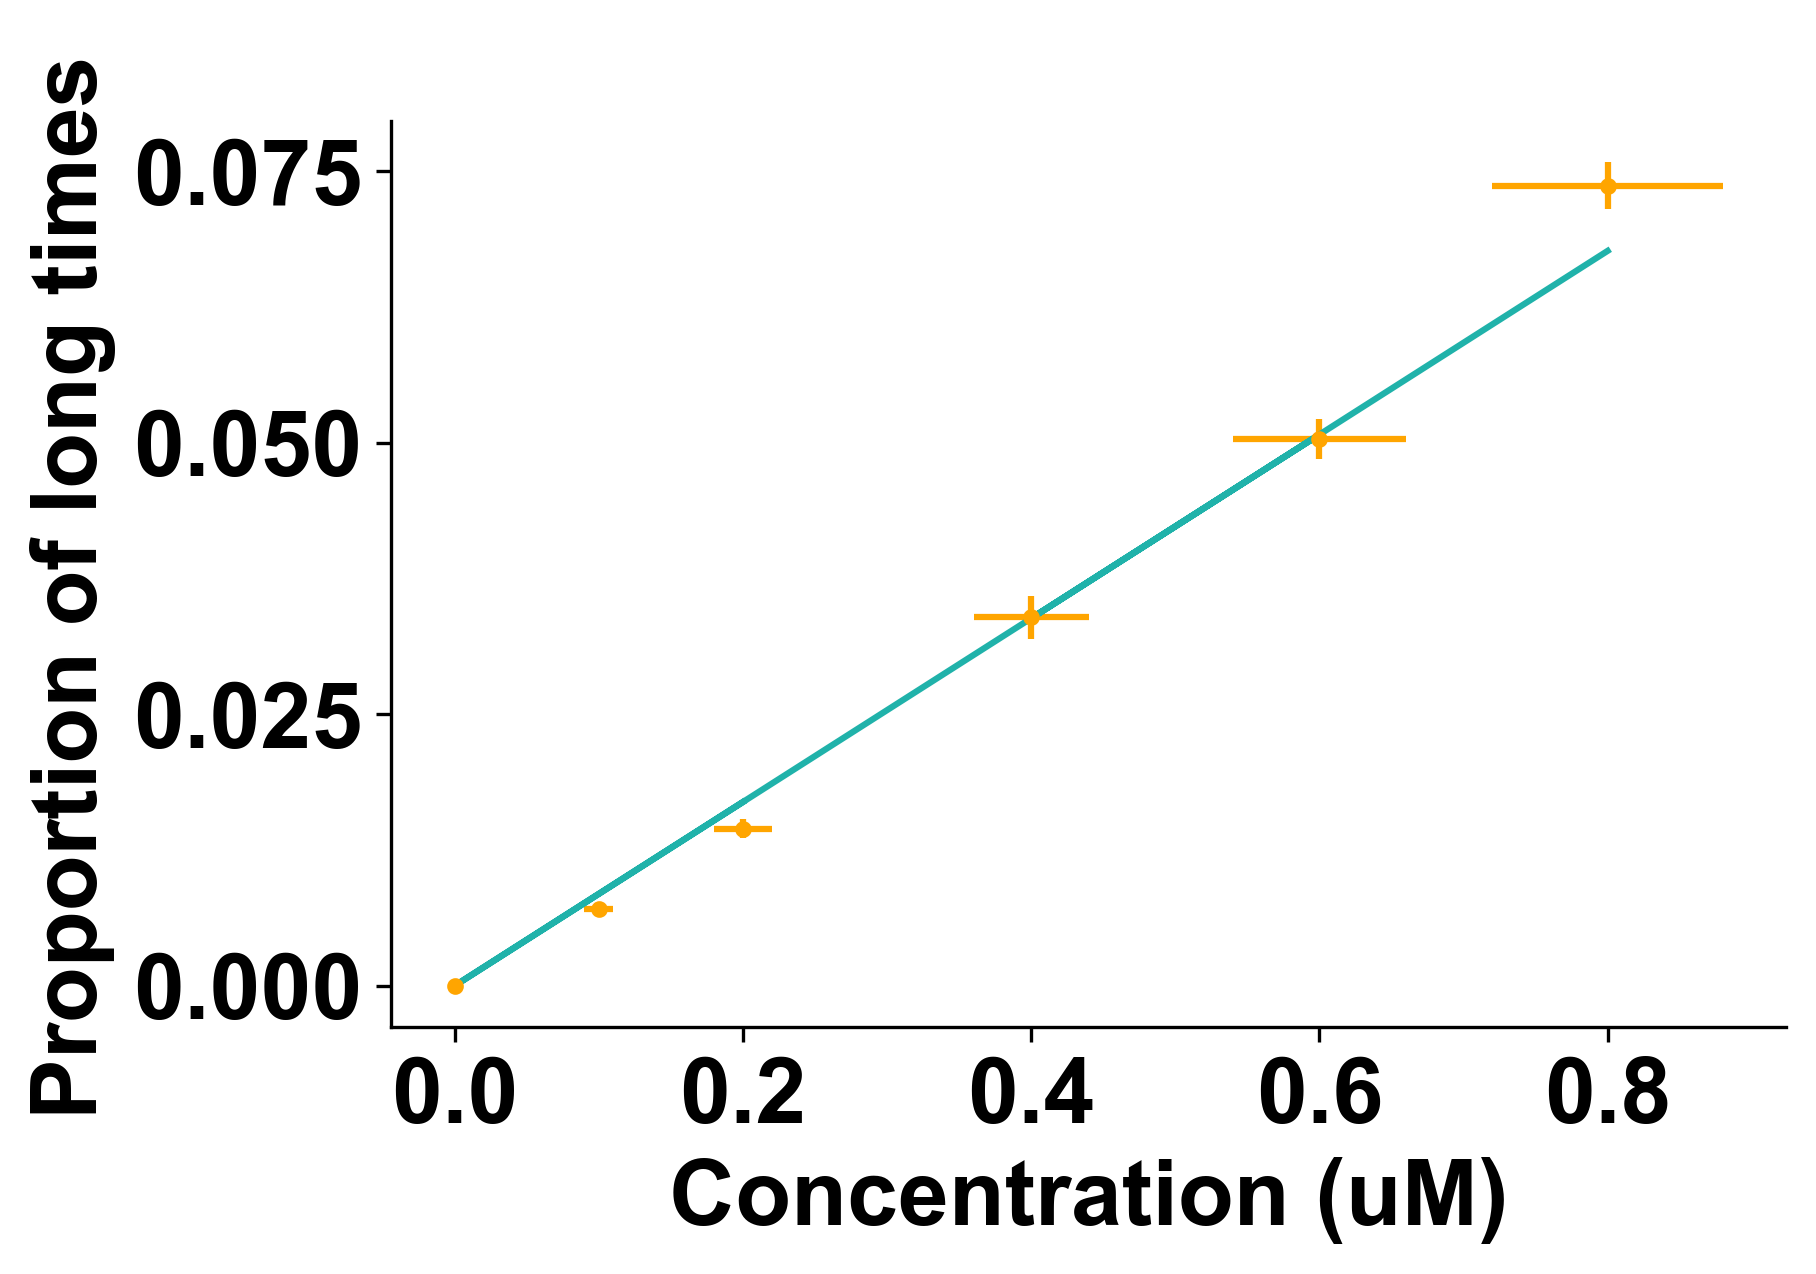

In [180]:
prop_long_times_vs_conc(times,conc,kf,koff)
plt.xlabel("Concentration (uM)")
